Data:
$$x_{true} \sim \mathcal{N}(\mu_p=0,\sigma_p=1)$$
$$x_{obs} \sim  \mathcal{N}(x_{true_i},0.5)$$


In [18]:

import numpy as np 
import scipy.stats as st
import pymc as pm
import matplotlib.pyplot as plt 
import arviz as az 
import pickle 
import pytensor.tensor as pt


In [19]:
Nobs=10**4

$$
\text{data generation:}
$$

$$
X \sim \mathcal{N}(\mu_p = 10, \, \sigma_p = 1)
$$
$$
X^{\text{obs}} \sim \mathcal{N}(\mu = X_i, \, \sigma = 0.5) 
\quad \sigma^2 = 0.5^2 \quad (\text{say})
$$
now imposing 
$$
X^{\text{obs}}>a \text{(taking arbritary , a=0 for now)}
$$

In [20]:
def gn(Nobs,mean,std,a,b):
    x = []
    while len(x) < Nobs:
        x1 = np.random.normal(mean, std)
        if (x1 <= a) or (x1 >= b):   
            x.append(x1)
    return np.array(x)

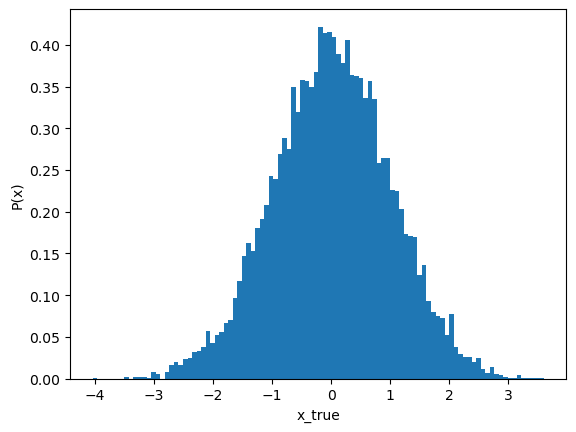

In [21]:
mu_p=0
sigma_p=1
x=gn(Nobs,mu_p,sigma_p,6,6)
plt.xlabel("x_true")
plt.ylabel("P(x)")
plt.hist(x,bins=100,density=True);

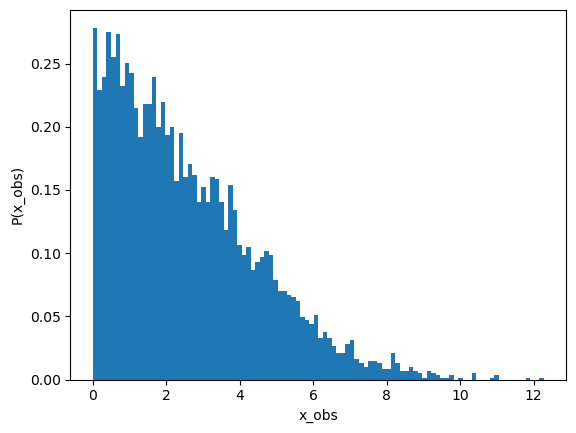

In [22]:
x_obs=[]
sigma_1=3
a=0
for i in range(Nobs):
    k=np.random.normal(x[i],sigma_1)
    if(k>a):
        x_obs.append(k)
    else :
        i=i-1
plt.xlabel("x_obs")
plt.ylabel("P(x_obs)")
plt.hist(x_obs,bins=100,density=True);
    

In [23]:
np.std(x_obs)

np.float64(1.9475712418768285)



$$
\text{Priors}
$$

$$
P(\mu_p) \sim U(0,20), 
\quad 
\sigma_p \sim U(0,5)
$$

$$
X \sim \mathcal{N}(\mu_p, \sigma_p)
$$

$$
\mathcal{L}(X_{\text{obs}} \mid\mu_p, \sigma_p) 
= \prod_{i=1}^{N_{\text{obs}}} \int \mathcal{L}(X^{\text{obs}}_i \mid X_i) \, P(X_i \mid \mu_p, \sigma_p) dX_i
$$

$$
= \prod_{i=1}^{N_{\text{obs}}} \int_X 
\mathcal{N}_{X^{\text{obs}}_i}(X_i, \sigma_i) \, \mathcal{N}_X(\mu_p, \sigma_p) \, dX_i
$$

$$
= \prod_{i=1}^{N_{\text{obs}}} \int_X 
\frac{1}{\sqrt{2\pi\sigma_i^2}} \,
\frac{1}{\sqrt{2\pi\sigma_p^2}} 
\exp\!\left( -\tfrac{1}{2} \Bigg[ 
\frac{(X_i^{\text{obs}} - X_i)^2}{\sigma_i^2} 
+ \frac{(X_i - \mu_p)^2}{\sigma_p^2} 
\Bigg] \right) \, dX_i
$$

$$
= \prod_{i=1}^{N_{\text{obs}}} \int_X A \, 
\exp\!\left( -\tfrac{1}{2} \Bigg( 
\frac{(X_i^{\text{obs}})^2}{\sigma_i^2} 
- 2 \frac{X_i X_i^{\text{obs}}}{\sigma_i^2} 
+ \frac{X_i^2}{\sigma_i^2} 
+ \frac{X_i^2}{\sigma_p^2} 
- 2 \frac{X_i \mu_p}{\sigma_p^2} 
+ \frac{\mu_p^2}{\sigma_p^2} 
\Bigg) \right) dX_i
$$


$$
= \prod_{i=1}^{N_{\text{obs}}} 
\int_X A \, \exp\!\left( 
-\tfrac{1}{2} \Bigg(
\frac{(X_i^{\text{obs}})^2}{\sigma_i^2} 
- 2 \frac{X_i X_i^{\text{obs}}}{\sigma_i^2} 
+ \frac{X_i^2}{\sigma_i^2} 
+ \frac{X_i^2}{\sigma_p^2} 
- 2 \frac{X_i \mu_p}{\sigma_p^2} 
+ \frac{\mu_p^2}{\sigma_p^2} 
\Bigg) \right) \, dX_i
$$

$$
= \prod_{i=1}^{N_{\text{obs}}} 
\int_X A \, \exp\!\left( 
-\tfrac{1}{2} \Bigg(
\left(\tfrac{1}{\sigma_i^2} + \tfrac{1}{\sigma_p^2}\right) X_i^2
- 2 \left(\tfrac{X_i^{\text{obs}}}{\sigma_i^2} + \tfrac{\mu_p}{\sigma_p^2}\right) X_i
+ \tfrac{(X_i^{\text{obs}})^2}{\sigma_i^2} + \tfrac{\mu_p^2}{\sigma_p^2}
\Bigg) \right) \, dX_i
$$

$$
= \prod_{i=1}^{N_{\text{obs}}} 
\int_X A \, 
\exp\!\left( -\tfrac{1}{2} 
\Big[ a X_i^2 - 2 b X_i + c \Big] \right) \, dX_i
$$

where

$$
a = \tfrac{1}{\sigma_i^2} + \tfrac{1}{\sigma_p^2}, 
\quad
b = \tfrac{X_i^{\text{obs}}}{\sigma_i^2} + \tfrac{\mu_p}{\sigma_p^2}, 
\quad
c = \tfrac{(X_i^{\text{obs}})^2}{\sigma_i^2} + \tfrac{\mu_p^2}{\sigma_p^2}.
$$


$$
\begin{aligned}
a &= \frac{1}{\sigma_i^2} + \frac{1}{\sigma_p^2}, \\[6pt]
b &= \frac{X_i^{\text{obs}}}{\sigma_i^2} + \frac{\mu_p}{\sigma_p^2}
= \frac{X_i^{\text{obs}}\sigma_p^2 + \mu_p\sigma_i^2}{\sigma_i^2\sigma_p^2}, \\[8pt]
c &= \frac{(X_i^{\text{obs}})^2}{\sigma_i^2} + \frac{\mu_p^2}{\sigma_p^2} \\

&= \frac{(X_i^{\text{obs}})^2\sigma_p^2 + \mu_p^2\sigma_i^2}{\sigma_i^2\sigma_p^2}, \\[10pt]
\text{Simplyfying the exponent term}\\
\frac{b^2}{a}
&= \frac{\big(X_i^{\text{obs}}\sigma_p^2 + \mu_p\sigma_i^2\big)^2}{\sigma_i^4\sigma_p^4}
\Big/ \frac{\sigma_i^2+\sigma_p^2}{\sigma_i^2\sigma_p^2} \\[6pt]
&= \frac{\big(X_i^{\text{obs}}\sigma_p^2 + \mu_p\sigma_i^2\big)^2}
{\sigma_i^2\sigma_p^2(\sigma_i^2+\sigma_p^2)}, \\[10pt]
c - \frac{b^2}{a}
&= \frac{\big((X_i^{\text{obs}})^2\sigma_p^2 + \mu_p^2\sigma_i^2\big)(\sigma_i^2+\sigma_p^2)
- \big(X_i^{\text{obs}}\sigma_p^2 + \mu_p\sigma_i^2\big)^2}
{\sigma_i^2\sigma_p^2(\sigma_i^2+\sigma_p^2)} \\[6pt]
&= \frac{(X_i^{\text{obs}})^2\sigma_p^2\sigma_i^2 + (X_i^{\text{obs}})^2\sigma_p^4 
+ \mu_p^2\sigma_i^4 + \mu_p^2\sigma_i^2\sigma_p^2
- \big((X_i^{\text{obs}})^2\sigma_p^4 + 2X_i^{\text{obs}}\mu_p\sigma_i^2\sigma_p^2 + \mu_p^2\sigma_i^4\big)}
{\sigma_i^2\sigma_p^2(\sigma_i^2+\sigma_p^2)} \\[6pt]
&= \frac{\sigma_i^2\sigma_p^2\big((X_i^{\text{obs}})^2 - 2X_i^{\text{obs}}\mu_p + \mu_p^2\big)}
{\sigma_i^2\sigma_p^2(\sigma_i^2+\sigma_p^2)} \\[6pt]
&= \frac{(X_i^{\text{obs}}-\mu_p)^2}{\sigma_i^2+\sigma_p^2}.
\end{aligned}
$$


Factor:
$$
\begin{aligned}
& A\sqrt{\frac{2*\pi}{a}}
&=\sqrt{\frac{2 \pi \sigma_1^2 {\sigma_p}^2 }{2 \pi \sigma_1^2 2\sigma_p^2 (\sigma_p^2+\sigma_1^2)}}\\
&= \sqrt{\frac{1}{\sigma_p^2+\sigma_1^2}}
\end{aligned}
$$

Hence :
$$
\mathcal{L}(X_{\text{obs}} \mid\mu_p, \sigma_p) 
= \prod_{i=1}^{N_{\text{obs}}} \mathcal{N}_{X_{\text{obs}}}(\mu_p, \sigma_p^2+\sigma_1^2)
$$


Now imposing the condition $X^{obs}_i >a$
From the defination of Conditional Probability we have:

Therefor now 
$$
\begin{align}
c\mathcal{L}(X^{obs}|\mu,\sigma)=\frac{P(X^{obs}|\mu,\sigma)}{P(X^{obs}>a|\mu,\sigma)}
\end{align}
$$
Where the Denominator is the normalizing factor
Now, 
$$
\begin{align}
P(X^{obs}>a) &=\int^\infty_a P(X^{obs}) dX^{obs}\\
&=\int^\infty_a \mathcal{N}_{X^{\text{obs}}}(\mu_p, \sigma_p^2+\sigma_1^2) dX^{obs}
\end{align}
$$


Therefore my posterior would be:
$$

P(\mu_p,\sigma_p \mid X^{\text{obs}_i}>a)=p(\mu_p)p(\sigma_p)\prod_{i=1}^{N_{\text{obs}}} \frac{\mathcal{N}_X^{\text{obs}}(\mu_p, \sigma_p^2+\sigma_1^2))}{\int^\infty_a \mathcal{N}_X^{\text{obs}}(\mu_p, \sigma_p^2+\sigma_1^2) dX^{obs}}\\
P(\mu_p,\sigma_p \mid X^{\text{obs}_i}>a)=p(\mu_p)p(\sigma_p)\prod_{i=1}^{N_{\text{obs}}} \frac{\mathcal{N}_X^{\text{obs}}(\mu_p, \sigma_p^2+\sigma_1^2))}{1-\int_{-\infty}^a \mathcal{N}_X^{\text{obs}}(\mu_p, \sigma_p^2+\sigma_1^2) dX^{obs}}
$$

Taking log , such that it is easier for us to define out model:
$$
log(P(\mu_p,\sigma_p \mid X^{\text{obs}_i}))=log(p(\mu_p))+log(p(\sigma_p))+\sum_{i=1}^{N_{\text{obs}}} \left( \log(\mathcal{N}_X^{\text{obs,i}}(\mu_p, \sigma_p^2+\sigma_1^2))-log(1-\int_{-\infty}^a \mathcal{N}_X^{\text{obs,i}}(\mu_p, \sigma_p^2+\sigma_1^2) dX^{obs,i}) )\right)
$$

In [24]:
print(np.shape(x_obs))

(4972,)


In [ ]:
with pm.Model() as model:
    # Priors
    mu = pm.Uniform("mu", -5, 5)
    sigma = pm.Uniform("sigma", 0,5)

    # Effective sigma with floor for stability
    s = pt.sqrt(sigma**2 + sigma_1**2)

    obs = pm.TruncatedNormal("obs", mu=mu, sigma=s, lower=0, observed=x_obs)


    trace = pm.sample(draws=3000, tune=3000, chains=4,core=4, target_accept=0.99)


c:\Users\User\anaconda3\envs\dm1\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 40 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.113,0.236,-0.573,0.317,0.005,0.005,1876.0,1928.0,1.0
sigma,1.257,0.273,0.766,1.778,0.007,0.008,1830.0,1552.0,1.0


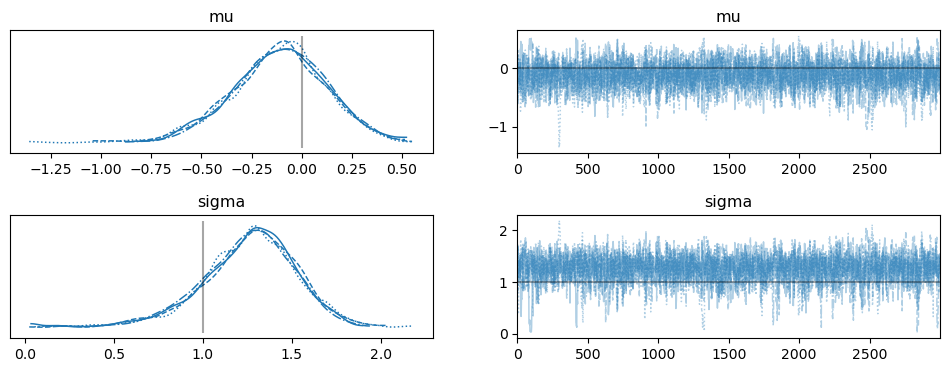

In [26]:
axes=az.plot_trace(            
        trace,
        compact=True,
        var_names=['mu', 'sigma'],
        lines=[
            ('mu', {}, mu_p),         # original mu_P
            ('sigma', {}, sigma_p),   # original sigma_P

        ]
    )
fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)
az.summary(trace)
